<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W3/ungraded_labs/C1_W3_Lab_2_exploring_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Exploring Convolutions

In this lab, you will explore how convolutions work by creating a basic convolution on a 2D grayscale image. First, you will load the image by taking the [ascent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.datasets.ascent.html) image from [SciPy](https://scipy.org/). It's a nice, built-in picture with lots of angles and lines.

In [5]:
from scipy.datasets import ascent

# load the ascent image
ascent_image = ascent()

You can use the pyplot library to draw the image so you'll know what it looks like.

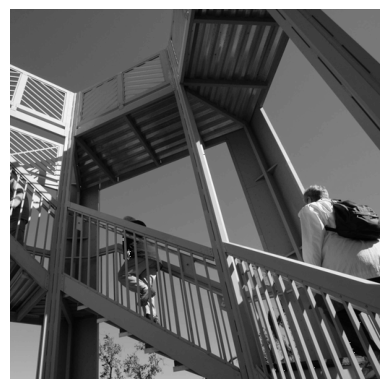

In [2]:
import matplotlib.pyplot as plt

# Visualize the image
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(ascent_image)
plt.show()

The image is stored as a numpy array so you can create the transformed image by first copying that array. You can also get the dimensions of the image so you can loop over it later.

In [11]:
import numpy as np

# Copy image to a numpy array
image_transformed = np.copy(ascent_image)

# Get the dimensions of the image
size_x = image_transformed.shape[0]
size_y = image_transformed.shape[1]

Now you can create a filter as a 3x3 array.

In [20]:
# Experiment with different values and see the effect
# filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]

# A couple more filters to try for fun!
filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
# filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# If all the digits in the filter don't add up to 0 or 1, you
# should probably do a weight to get it to do so
# so, for example, if your weights are 1,1,1 1,2,1 1,1,1
# They add up to 10, so you would set a weight of .1 if you want to normalize them
weight  = 1

Now you can create a convolution. You will iterate over the image, leaving a 1 pixel margin, and multiplying each of the neighbors of the current pixel by the value defined in the filter (i.e. the current pixel's neighbor above it and to the left will be multiplied by the top left item in the filter, etc.)

You'll then multiply the result by the weight, and then ensure the result is in the range 0-255.

Finally you'll load the new value into the transformed image.

In [13]:
# Iterate over the image
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (ascent_image[x-1, y-1] * filter[0][0])
      convolution = convolution + (ascent_image[x-1, y] * filter[0][1])
      convolution = convolution + (ascent_image[x-1, y+1] * filter[0][2])
      convolution = convolution + (ascent_image[x, y-1] * filter[1][0])
      convolution = convolution + (ascent_image[x, y] * filter[1][1])
      convolution = convolution + (ascent_image[x, y+1] * filter[1][2])
      convolution = convolution + (ascent_image[x+1, y-1] * filter[2][0])
      convolution = convolution + (ascent_image[x+1, y] * filter[2][1])
      convolution = convolution + (ascent_image[x+1, y+1] * filter[2][2])

      # Multiply by weight
      convolution = convolution * weight

      # Check the boundaries of the pixel values
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255

      # Load into the transformed image
      image_transformed[x, y] = convolution

In [34]:
import tensorflow as tf

# Convert the image and filter to tensors
ascent_image_tensor = tf.convert_to_tensor(ascent_image, dtype=tf.float32)
filter_tensor = tf.convert_to_tensor(filter, dtype=tf.float32)

# Add extra dimensions needed for the convolution function
ascent_image_tensor = tf.expand_dims(tf.expand_dims(ascent_image_tensor, axis=-1), axis=0)
filter_tensor = tf.expand_dims(tf.expand_dims(filter_tensor, axis=-1), axis=-1)

# Perform the convolution operation
convolution = tf.nn.convolution(input=ascent_image_tensor, filters=filter_tensor, padding="VALID")

# Multiply by weight
convolution = convolution * weight

# Check the boundaries of the pixel values
convolution = tf.clip_by_value(convolution, clip_value_min=0, clip_value_max=255)

# Remove the extra dimensions
convolution = tf.squeeze(convolution)

# Convert the tensor back to a numpy array
image_transformed_tf = convolution.numpy()

In [22]:
print(filter)
# print sum of all values in the filter
print(f"Sum of values in filter is: {np.sum(filter)}")

[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
Sum of values in filter is: 0


In [26]:
from scipy.ndimage import convolve

# Define the filter
filter = np.array([ [0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=float)

# Apply the filter using convolve function
image_transformed = convolve(ascent_image, filter)
# Multiply by weight
image_transformed = image_transformed * weight

# Ensure the pixel values are within the range 0-255
image_transformed_scipy = np.clip(image_transformed, 0, 255)

After the loop, you can now plot the image to see the effect of the convolution!

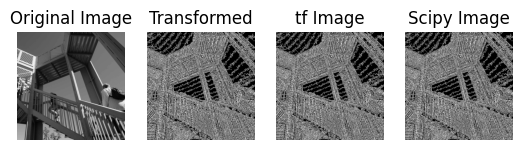

In [31]:
# Display the original ascent image
plt.subplot(1, 4, 1)  # 1 row, 2 columns, index 1
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(ascent_image)
plt.title('Original Image')

# Display the transformed image
plt.subplot(1, 4, 2)  # 1 row, 2 columns, index 2
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(image_transformed)
plt.title('Transformed')

# Display the tf transformed image
plt.subplot(1, 4, 3)  # 1 row, 2 columns, index 2
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(image_transformed)
plt.title('tf Image')


# Display the scipy transformed image
plt.subplot(1, 4, 4)  # 1 row, 2 columns, index 2
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(image_transformed_scipy)
plt.title('Scipy Image')


plt.show()

## Effect of Max Pooling

The next cell will show a (2, 2) pooling. The idea here is to iterate over the image, and look at the pixel and it's immediate neighbors to the right, beneath, and right-beneath. It will take the largest of them and load it into the new image. Thus, the new image will be 1/4 the size of the old -- with the dimensions on X and Y being halved by this process. You'll see that the features get maintained despite this compression!

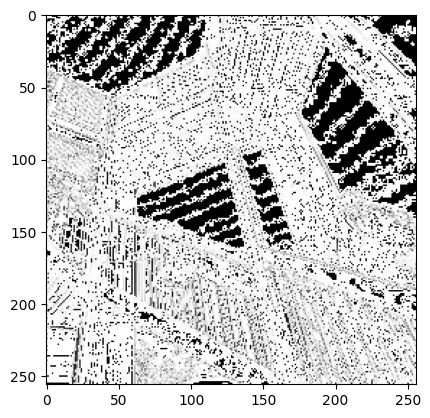

In [32]:
# Assign dimensions half the size of the original image
new_x = int(size_x/2)
new_y = int(size_y/2)

# Create blank image with reduced dimensions
newImage = np.zeros((new_x, new_y))

# Iterate over the image
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):

    # Store all the pixel values in the (2,2) pool
    pixels = []
    pixels.append(image_transformed[x, y])
    pixels.append(image_transformed[x+1, y])
    pixels.append(image_transformed[x, y+1])
    pixels.append(image_transformed[x+1, y+1])

    # Get only the largest value and assign to the reduced image
    newImage[int(x/2),int(y/2)] = max(pixels)

# Plot the image. Note the size of the axes -- it is now 256 pixels instead of 512
plt.gray()
plt.grid(False)
plt.imshow(newImage)
plt.show()

Shape of image_transformed_tf:  (510, 510)
Shape of image_transformed_tf:  (1, 510, 510, 1)


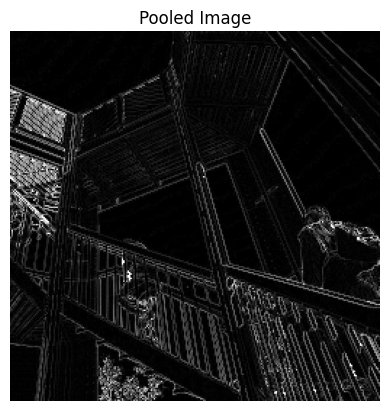

In [41]:
import tensorflow as tf

# Convert the image and filter to tensors
ascent_image_tensor = tf.convert_to_tensor(ascent_image, dtype=tf.float32)
filter_tensor = tf.convert_to_tensor(filter, dtype=tf.float32)

# Add extra dimensions needed for the convolution function
ascent_image_tensor = tf.expand_dims(tf.expand_dims(ascent_image_tensor, axis=-1), axis=0)
filter_tensor = tf.expand_dims(tf.expand_dims(filter_tensor, axis=-1), axis=-1)

# Perform the convolution operation
convolution = tf.nn.convolution(input=ascent_image_tensor, filters=filter_tensor, padding="VALID")

# Multiply by weight
convolution = convolution * weight

# Check the boundaries of the pixel values
convolution = tf.clip_by_value(convolution, clip_value_min=0, clip_value_max=255)

# Remove the extra dimensions
convolution = tf.squeeze(convolution)

# Convert the tensor back to a numpy array
image_transformed_tf = convolution.numpy()

# Perform max pooling operation
pool_size = 2
pool_stride = 2

print("Shape of image_transformed_tf (before): ", image_transformed_tf.shape)

image_transformed_tf = tf.expand_dims(image_transformed_tf, axis=0) # add batch dimension to start
image_transformed_tf = tf.expand_dims(image_transformed_tf, axis=-1) # add channel dimension to end

print("Shape of image_transformed_tf (after): ", image_transformed_tf.shape)

image_pooled = tf.nn.max_pool2d(input=(image_transformed_tf), # NHWC format
                                ksize=[1, pool_size, pool_size, 1], 
                                strides=[1, pool_stride, pool_stride, 1], 
                                padding='VALID')

# Remove the extra dimensions
image_pooled = tf.squeeze(image_pooled)

# Convert the tensor back to a numpy array
image_pooled_np = image_pooled.numpy()

# Display the pooled image
plt.gray()
plt.grid(False)
plt.axis('off')
plt.imshow(image_pooled_np)
plt.title('Pooled Image')
plt.show()